<a href="https://colab.research.google.com/github/tallywiesenberg/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#pipeline imports
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegressionCV

     |████████████████████████████████| 102kB 2.7MB/s 


#Import

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
from google.colab import drive
drive.mount('/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive/


In [4]:
#crash data
crashes = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Crashes_in_DC.csv', dtype={'STREETSEGID': 'Int64'})  #crash data
crashes1 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Crash_Details_Table.csv', dtype={'STREETSEGID': 'Int64'}) #additional crash data
crashes.shape, crashes1.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,54,55) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



((217602, 56), (470660, 15))

In [5]:
crashes.head(2)

,X,Y,OBJECTID,CRIMEID,CCN,REPORTDATE,ROUTEID,MEASURE,OFFSET,STREETSEGID,ROADWAYSEGID,FROMDATE,TODATE,MARID,ADDRESS,LATITUDE,LONGITUDE,XCOORD,YCOORD,WARD,EVENTID,MAR_ADDRESS,MAR_SCORE,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_DRIVER,MINORINJURIES_DRIVER,UNKNOWNINJURIES_DRIVER,FATAL_DRIVER,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,PEDESTRIANSIMPAIRED,BICYCLISTSIMPAIRED,DRIVERSIMPAIRED,TOTAL_TAXIS,TOTAL_GOVERNMENT,SPEEDING_INVOLVED,NEARESTINTROUTEID,NEARESTINTSTREETNAME,OFFINTERSECTION,INTAPPROACHDIRECTION,LOCATIONERROR,LASTUPDATEDATE,MPDLATITUDE,MPDLONGITUDE,MPDGEOX,MPDGEOY,BLOCKKEY,SUBBLOCKKEY
0,-76.980766,38.889685,109482909,27191710,17010515,2017-01-19T18:56:20.000Z,13001702,13.411,0.000000,5431,2398.0,2017-01-19T05:00:00.000Z,NaN,58951,21 17TH ST SE,38.889678,-76.98071,401668.840,135759.618,Ward 6,{9AC03520-FDDA-4D43-848E-95EAF2FC8E74},1635 EAST CAPITOL STREET SE,200.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,12001702,17TH ST NE,14.334858,South,NaN,NaN,38.889678,-76.980710,NaN,NaN,NaN,NaN
1,-77.029993,38.952914,109482910,27688005,18085167,2018-05-27T05:47:21.000Z,11042902,25.472,19.612804,6921,9510.0,2018-05-26T04:00:00.000Z,NaN,254976,5200 13TH STREET NW,38.952907,-77.02999,397400.439,142778.768,Ward 4,{5B7C4496-EAFE-4681-BFE4-602357ADBA39},5200 13TH STREET NW,200.0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,11001302,13TH ST NW,2.464102,West,NaN,2018-05-30T14:33:06.000Z,38.952885,-77.029683,397400.55,142798.38,NaN,NaN


In [6]:
crashes1.head()

,OBJECTID,CRIMEID,CCN,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,226315330,24598083,13064967,84902881,Driver,0,N,N,N,948586,Passenger Car/automobile,N,MD,N,N
1,226315331,24598083,13064967,84876790,Driver,32,N,N,N,948587,Passenger Car/automobile,N,DC,N,N
2,226315332,24598083,13064967,84828817,Driver,0,N,Y,N,948588,Passenger Car/automobile,N,DC,N,N
3,226315333,24598083,13064967,84819235,Driver,53,N,N,N,948588,Passenger Car/automobile,N,DC,N,N
4,226315334,24598083,13064967,84698030,Driver,44,N,N,N,948586,Passenger Car/automobile,N,MD,N,N


##Pre-merge cleaning

In [0]:
car_types = crashes1.groupby('CRIMEID')['INVEHICLETYPE'].value_counts().unstack().replace(np.nan, 0).reset_index()

In [0]:
crashes1['SENIORS'] = crashes1['AGE'] > 65
crashes1['CHILDREN'] = crashes1['AGE'] < 18

In [0]:
seniors = crashes1.groupby('CRIMEID')['SENIORS'].value_counts().unstack().reset_index().replace(np.nan, 0).drop(columns=False)
children = crashes1.groupby('CRIMEID')['CHILDREN'].value_counts().unstack().reset_index().replace(np.nan, 0).drop(columns=False)

##Merge

In [0]:
#datasets for engineering
street_segs = pd.read_csv('https://opendata.arcgis.com/datasets/f21813094ed24fd5ba66a07b61a1acee_46.csv', dtype={'STREETSEGID': 'Int64'})
bicycles = pd.read_csv('https://opendata.arcgis.com/datasets/294e062cdf2c48d5b9cbc374d9709bc0_2.csv', dtype={'STREETSEGID': 'Int64'})

need to aggregate crashes1 (personal crash data)

In [11]:
df = crashes.merge(car_types, how='inner', on='CRIMEID')   #inner join on CRIMEID, the common unique ID between datasets
df = df.merge(seniors, how='inner', on='CRIMEID')
df = df.merge(children, how='inner', on='CRIMEID')
df = df.merge(street_segs[['STREETSEGID', 'STREETTYPE', 'QUADRANT', 'DIRECTIONALITY']], how='left', on='STREETSEGID')
df = df.merge(bicycles[['STREETSEGID', 'BIKELANELENGTH']], how='left', on='STREETSEGID')
df.shape

(215577, 84)

In [12]:
df= df.sort_index(axis=1)
df.head()

,ADDRESS,Aircraft,Atv (all Terrain Vehicle),BICYCLISTSIMPAIRED,BIKELANELENGTH,BLOCKKEY,Bus,CCN,CRIMEID,Cargo Van,Construction/industrial Equipment,DIRECTIONALITY,DRIVERSIMPAIRED,Drugs/ Narcotics,EVENTID,FATAL_BICYCLIST,FATAL_DRIVER,FATAL_PEDESTRIAN,FROMDATE,Farm Equipment,Firearms,INTAPPROACHDIRECTION,LASTUPDATEDATE,LATITUDE,LOCATIONERROR,LONGITUDE,Large/heavy Truck,MAJORINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MARID,MAR_ADDRESS,MAR_SCORE,MEASURE,MINORINJURIES_BICYCLIST,MINORINJURIES_DRIVER,MINORINJURIES_PEDESTRIAN,MPDGEOX,MPDGEOY,MPDLATITUDE,MPDLONGITUDE,Moped/scooter,Motor Cycle,Motorhome/camper/rv (recreational Vehicle),NEARESTINTROUTEID,NEARESTINTSTREETNAME,None,OBJECTID,OFFINTERSECTION,OFFSET,Other Small/light Truck,Other Vehicle,PEDESTRIANSIMPAIRED,Passenger Car/automobile,Passenger Van,Pickup Truck,QUADRANT,REPORTDATE,ROADWAYSEGID,ROUTEID,SPEEDING_INVOLVED,STREETSEGID,STREETTYPE,SUBBLOCKKEY,Snow Mobile,Suv (sport Utility Vehicle),TODATE,TOTAL_BICYCLES,TOTAL_GOVERNMENT,TOTAL_PEDESTRIANS,TOTAL_TAXIS,TOTAL_VEHICLES,Trailer,True_x,True_y,UNKNOWNINJURIES_BICYCLIST,UNKNOWNINJURIES_DRIVER,UNKNOWNINJURIES_PEDESTRIAN,WARD,Watercraft/boat,X,XCOORD,Y,YCOORD
0,21 17TH ST SE,0.0,0.0,0,NaN,NaN,0.0,17010515,27191710,0.0,0.0,0.0,0,0.0,{9AC03520-FDDA-4D43-848E-95EAF2FC8E74},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,South,NaN,38.889678,NaN,-76.980710,0.0,0,0,0,58951,1635 EAST CAPITOL STREET SE,200.0,13.411,0,0,0,NaN,NaN,38.889678,-76.980710,0.0,0.0,0.0,12001702,17TH ST NE,0.0,109482909,14.334858,0.000000,0.0,0.0,0,1.0,0.0,0.0,SE,2017-01-19T18:56:20.000Z,2398.0,13001702,0,5431,ST,NaN,0.0,2.0,NaN,0,1,0,0,2,0.0,0.0,0.0,0,0,0,Ward 6,0.0,-76.980766,401668.840,38.889685,135759.618
1,5200 13TH STREET NW,0.0,0.0,0,NaN,NaN,0.0,18085167,27688005,0.0,0.0,2.0,0,0.0,{5B7C4496-EAFE-4681-BFE4-602357ADBA39},0,0,0,2018-05-26T04:00:00.000Z,0.0,0.0,West,2018-05-30T14:33:06.000Z,38.952907,NaN,-77.029990,0.0,0,0,0,254976,5200 13TH STREET NW,200.0,25.472,0,2,0,397400.55,142798.38,38.952885,-77.029683,0.0,0.0,0.0,11001302,13TH ST NW,0.0,109482910,2.464102,19.612804,0.0,0.0,0,2.0,0.0,0.0,NW,2018-05-27T05:47:21.000Z,9510.0,11042902,0,6921,ST,NaN,0.0,0.0,NaN,0,0,0,0,2,0.0,0.0,0.0,0,0,0,Ward 4,0.0,-77.029993,397400.439,38.952914,142778.768
2,956 MOUNT OLIVET ROAD NE,0.0,0.0,0,NaN,NaN,0.0,17147314,27412026,0.0,0.0,NaN,0,0.0,{AA7672E8-9AD6-4DF5-99A2-485C44F778AC},0,0,0,2017-08-25T04:00:00.000Z,0.0,0.0,East,NaN,38.912530,NaN,-76.989323,0.0,0,0,0,285877,1125 OKIE STREET NE,200.0,6.668,0,1,0,400869.06,138300.03,38.912540,-76.989318,0.0,0.0,0.0,12062462,MOUNT OLIVET RD NE,0.0,109482911,81.113797,1.181367,0.0,0.0,0,1.0,0.0,0.0,NaN,2017-08-26T04:18:45.000Z,28725.0,47061782,0,-9,NaN,NaN,0.0,0.0,NaN,0,0,0,0,1,0.0,0.0,0.0,0,0,0,Ward 5,0.0,-76.989326,400925.959,38.912538,138296.279
3,77 FORRESTER STREET SW,0.0,0.0,0,NaN,NaN,0.0,17010532,27191714,0.0,0.0,0.0,0,0.0,{A4BB396B-2DAA-4132-AE90-3DBB53E718F4},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,West,NaN,38.825274,NaN,-77.009778,0.0,0,0,0,82880,95 FORRESTER STREET SW,200.0,263.347,0,0,0,399157.70,128623.88,38.825274,-77.009778,0.0,0.0,0.0,14039322,GALVESTON PL SW,0.0,109482912,172.288758,0.000000,0.0,0.0,0,1.0,0.0,0.0,SW,2017-01-19T19:01:35.000Z,1052.0,14036982,0,2270,ST,NaN,0.0,0.0,NaN,0,0,0,0,4,0.0,0.0,0.0,0,0,0,Ward 8,0.0,-77.009782,399150.748,38.825201,128601.264
4,2200 SOUTH DAKOTA AVENUE NE,0.0,0.0,0,NaN,NaN,0.0,17010514,27191715,0.0,0.0,2.0,0,0.0,{EF8064CF-B419-468F-B0D2-D5F777142E35},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,Northwest,NaN,38.920464,NaN,-76.957954,1.0,0,0,0,304441,3320 THEODORE R HAGANS DRIVE NE,200.0,372.161,0,0,0,403599.77,139127.65,38.920464,-76.957954,0.0,0.0,0.0,12003332,33RD PL NE,0.0,109482913,56.061139,0.000000,0.0,0.0,0,1.0,0.0,0.0,NE,2017-01-19T19:01:37.000Z,36763.0,12081442,0,9851,AVE,NaN,0.0,0.0,NaN,0,0,0,0,2,0.0,2.0,0.0,0,0,0,Ward 5,0.0,-76.958041,403638.852,38.920396,139169.372


#Cleaning

In [13]:
df.head()

,ADDRESS,Aircraft,Atv (all Terrain Vehicle),BICYCLISTSIMPAIRED,BIKELANELENGTH,BLOCKKEY,Bus,CCN,CRIMEID,Cargo Van,Construction/industrial Equipment,DIRECTIONALITY,DRIVERSIMPAIRED,Drugs/ Narcotics,EVENTID,FATAL_BICYCLIST,FATAL_DRIVER,FATAL_PEDESTRIAN,FROMDATE,Farm Equipment,Firearms,INTAPPROACHDIRECTION,LASTUPDATEDATE,LATITUDE,LOCATIONERROR,LONGITUDE,Large/heavy Truck,MAJORINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MARID,MAR_ADDRESS,MAR_SCORE,MEASURE,MINORINJURIES_BICYCLIST,MINORINJURIES_DRIVER,MINORINJURIES_PEDESTRIAN,MPDGEOX,MPDGEOY,MPDLATITUDE,MPDLONGITUDE,Moped/scooter,Motor Cycle,Motorhome/camper/rv (recreational Vehicle),NEARESTINTROUTEID,NEARESTINTSTREETNAME,None,OBJECTID,OFFINTERSECTION,OFFSET,Other Small/light Truck,Other Vehicle,PEDESTRIANSIMPAIRED,Passenger Car/automobile,Passenger Van,Pickup Truck,QUADRANT,REPORTDATE,ROADWAYSEGID,ROUTEID,SPEEDING_INVOLVED,STREETSEGID,STREETTYPE,SUBBLOCKKEY,Snow Mobile,Suv (sport Utility Vehicle),TODATE,TOTAL_BICYCLES,TOTAL_GOVERNMENT,TOTAL_PEDESTRIANS,TOTAL_TAXIS,TOTAL_VEHICLES,Trailer,True_x,True_y,UNKNOWNINJURIES_BICYCLIST,UNKNOWNINJURIES_DRIVER,UNKNOWNINJURIES_PEDESTRIAN,WARD,Watercraft/boat,X,XCOORD,Y,YCOORD
0,21 17TH ST SE,0.0,0.0,0,NaN,NaN,0.0,17010515,27191710,0.0,0.0,0.0,0,0.0,{9AC03520-FDDA-4D43-848E-95EAF2FC8E74},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,South,NaN,38.889678,NaN,-76.980710,0.0,0,0,0,58951,1635 EAST CAPITOL STREET SE,200.0,13.411,0,0,0,NaN,NaN,38.889678,-76.980710,0.0,0.0,0.0,12001702,17TH ST NE,0.0,109482909,14.334858,0.000000,0.0,0.0,0,1.0,0.0,0.0,SE,2017-01-19T18:56:20.000Z,2398.0,13001702,0,5431,ST,NaN,0.0,2.0,NaN,0,1,0,0,2,0.0,0.0,0.0,0,0,0,Ward 6,0.0,-76.980766,401668.840,38.889685,135759.618
1,5200 13TH STREET NW,0.0,0.0,0,NaN,NaN,0.0,18085167,27688005,0.0,0.0,2.0,0,0.0,{5B7C4496-EAFE-4681-BFE4-602357ADBA39},0,0,0,2018-05-26T04:00:00.000Z,0.0,0.0,West,2018-05-30T14:33:06.000Z,38.952907,NaN,-77.029990,0.0,0,0,0,254976,5200 13TH STREET NW,200.0,25.472,0,2,0,397400.55,142798.38,38.952885,-77.029683,0.0,0.0,0.0,11001302,13TH ST NW,0.0,109482910,2.464102,19.612804,0.0,0.0,0,2.0,0.0,0.0,NW,2018-05-27T05:47:21.000Z,9510.0,11042902,0,6921,ST,NaN,0.0,0.0,NaN,0,0,0,0,2,0.0,0.0,0.0,0,0,0,Ward 4,0.0,-77.029993,397400.439,38.952914,142778.768
2,956 MOUNT OLIVET ROAD NE,0.0,0.0,0,NaN,NaN,0.0,17147314,27412026,0.0,0.0,NaN,0,0.0,{AA7672E8-9AD6-4DF5-99A2-485C44F778AC},0,0,0,2017-08-25T04:00:00.000Z,0.0,0.0,East,NaN,38.912530,NaN,-76.989323,0.0,0,0,0,285877,1125 OKIE STREET NE,200.0,6.668,0,1,0,400869.06,138300.03,38.912540,-76.989318,0.0,0.0,0.0,12062462,MOUNT OLIVET RD NE,0.0,109482911,81.113797,1.181367,0.0,0.0,0,1.0,0.0,0.0,NaN,2017-08-26T04:18:45.000Z,28725.0,47061782,0,-9,NaN,NaN,0.0,0.0,NaN,0,0,0,0,1,0.0,0.0,0.0,0,0,0,Ward 5,0.0,-76.989326,400925.959,38.912538,138296.279
3,77 FORRESTER STREET SW,0.0,0.0,0,NaN,NaN,0.0,17010532,27191714,0.0,0.0,0.0,0,0.0,{A4BB396B-2DAA-4132-AE90-3DBB53E718F4},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,West,NaN,38.825274,NaN,-77.009778,0.0,0,0,0,82880,95 FORRESTER STREET SW,200.0,263.347,0,0,0,399157.70,128623.88,38.825274,-77.009778,0.0,0.0,0.0,14039322,GALVESTON PL SW,0.0,109482912,172.288758,0.000000,0.0,0.0,0,1.0,0.0,0.0,SW,2017-01-19T19:01:35.000Z,1052.0,14036982,0,2270,ST,NaN,0.0,0.0,NaN,0,0,0,0,4,0.0,0.0,0.0,0,0,0,Ward 8,0.0,-77.009782,399150.748,38.825201,128601.264
4,2200 SOUTH DAKOTA AVENUE NE,0.0,0.0,0,NaN,NaN,0.0,17010514,27191715,0.0,0.0,2.0,0,0.0,{EF8064CF-B419-468F-B0D2-D5F777142E35},0,0,0,2017-01-19T05:00:00.000Z,0.0,0.0,Northwest,NaN,38.920464,NaN,-76.957954,1.0,0,0,0,304441,3320 THEODORE R HAGANS DRIVE NE,200.0,372.161,0,0,0,403599.77,139127.65,38.920464,-76.957954,0.0,0.0,0.0,12003332,33RD PL NE,0.0,109482913,56.061139,0.000000,0.0,0.0,0,1.0,0.0,0.0,NE,2017-01-19T19:01:37.000Z,36763.0,12081442,0,9851,AVE,NaN,0.0,0.0,NaN,0,0,0,0,2,0.0,2.0,0.0,0,0,0,Ward 5,0.0,-76.958041,403638.852,38.920396,139169.372


In [14]:
#create time series from date of crash
df['FROMDATE'] = pd.to_datetime(df['FROMDATE'].str.slice(stop=10), infer_datetime_format = True)
df['FROMDATE'].head()

0   2017-01-19
1   2018-05-26
2   2017-08-25
3   2017-01-19
4   2017-01-19
Name: FROMDATE, dtype: datetime64[ns]

In [0]:
#drop observations recorded before 2000 because they are date entry errors (judgement call)

df.drop(df.query('FROMDATE < 2000').index, inplace=True)


In [16]:
df['FROMDATE'].describe()

count                  215529
unique                   4354
top       2019-06-13 00:00:00
freq                      251
first     2000-01-01 00:00:00
last      2019-09-26 00:00:00
Name: FROMDATE, dtype: object

In [0]:
#drop duplicate and ID columns
df = df.drop(columns=['OBJECTID', 'CCN', 'EVENTID', 'BLOCKKEY', 'EVENTID', 'None'])  #"none" column is leftover from car_types merge, it means no cars were involved (illogical)

In [0]:
#cleaning STREET SEGMENT ID
df['STREETSEGID'] = (df['STREETSEGID'].replace(-9.0, np.nan)   #-9 is not a valid street segment id
                                      .replace(0.0, np.nan)    #0 isnt a valid street segment id
#                                       .astype(int)
                    )
#cleaning WARD attribute
mode = df['WARD'].mode()[0]                                      #mode of WARD attribute

df['WARD'] = df['WARD'].replace('Null', np.nan).fillna(value=df['WARD'].mode()[0])  #fill WARD attribute with mode of column (useful so column can be converted to int dtype)
df['WARD'] = df['WARD'].str.replace('Ward ', '').astype(int)   #remove "ward" string from ward attribute


In [0]:
# impute_mode = SimpleImputer(strategy='most_frequent')
# impute_mean = SimpleImputer(strategy='median')

# impute_mode.fit_transform(df.select_dtypes('object'))
# impute_mean.fit_transform(df.select_dtypes('number'))

In [20]:
#change Y/N to 0/1
#will return an error, but still works?
diction = {'N': 0, 'Y': 1}
for col in df.columns:
  if (df[col].unique().tolist() == ['N', 'Y']) | (df[col].unique().tolist() == ['Y', 'N']):
    df[col] = df[col].replace(diction)
  else:
    pass

AttributeError: ignored

In [0]:
#change missing values of BIKELANELENGTH attribute to 0s
#soon to be dropped, just need to know if there is a bikelane or not
df['BIKELANELENGTH'] = df['BIKELANELENGTH'].replace(np.nan, 0)

In [22]:
#drop columns where missing values are 35 percent or more of column

for col in df.columns:
  if df[col].isna().sum() >= .5 * df.shape[0]:
    df = df.drop(columns=col)
  else:
    pass
  
df.shape

(215536, 73)

#Engineering

In [0]:
#all the features that will be summed to become the target variable

target_cols = df.columns[df.columns.str.contains('FATAL') | df.columns.str.contains('MAJOR')].tolist()

target_numeric = df[target_cols].agg('sum', axis='columns')  #target column formatted numerically

target_mask = target_numeric > 0                             #target mask returns with either True (major injury or fatality) or False (no major injury or fatality)

df['MAJOR_INJURY_OR_FATAL'] = target_mask

diction = {False: 0, True: 1}                                #change True/False to 0/1
df['MAJOR_INJURY_OR_FATAL'] = df['MAJOR_INJURY_OR_FATAL'].replace(diction)

In [24]:
df['MAJOR_INJURY_OR_FATAL'].value_counts()


0    199482
1     16054
Name: MAJOR_INJURY_OR_FATAL, dtype: int64

In [25]:
##Bike lanes
diction = {False: 1, True: 0}

df['BIKE_LANE'] = df['BIKELANELENGTH'] == 0        #is there a bikelane (this is after NaNs are replaced with 0s)
df['BIKE_LANE'] = df['BIKE_LANE'].replace(diction) #0 means no bikelane, 1 means bikelane

df['BIKE_LANE'].value_counts()

#drop BIKELANELENGTH, YEARINSTALLED, no longer useful
print(df.shape)
df = df.drop('BIKELANELENGTH', axis = 1)
print(df.shape)

(215536, 75)
(215536, 74)


In [26]:
#YEAR of accident

df['YEAR'] = df['FROMDATE'].dt.year
df['YEAR'].value_counts()

2016.0    26397
2017.0    26275
2018.0    26031
2015.0    22155
2019.0    19969
2014.0    19287
2013.0    17434
2012.0    16433
2011.0    13283
2009.0    12786
2010.0    12542
2008.0     2727
2000.0      126
2006.0       22
2007.0       17
2005.0       16
2001.0       13
2004.0        6
2003.0        5
2002.0        5
Name: YEAR, dtype: int64

#Baseline Model

In [27]:
df['MAJOR_INJURY_OR_FATAL'].value_counts()

0    199482
1     16054
Name: MAJOR_INJURY_OR_FATAL, dtype: int64

In [28]:
df['MAJOR_INJURY_OR_FATAL'].value_counts(normalize=True)

0    0.925516
1    0.074484
Name: MAJOR_INJURY_OR_FATAL, dtype: float64

In [29]:
y_pred = [0] * df.shape[0]
print('Baseline accuracy score:', accuracy_score(df['MAJOR_INJURY_OR_FATAL'], y_pred))
#Despite high accuracy, baseline model is useless because false negatives are very costly to society
print(confusion_matrix(df['MAJOR_INJURY_OR_FATAL'], y_pred))

print(16054/199482)

Baseline accuracy score: 0.9255159230940538
[[199482      0]
 [ 16054      0]]
0.08047843915741772


#Exploration

In [0]:
df.head(2)

In [0]:
df.groupby('WARD')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()
plt.title('Probability of Major Injury or Death from Car Accident by DC Ward')

In [0]:
df.groupby('BIKE_LANE')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df.groupby('DRIVERSIMPAIRED')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df.groupby('SPEEDING')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df.groupby('INTAPPROACHDIRECTION')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df.groupby('SPEEDING_INVOLVED')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df.groupby('STREETTYPE')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [0]:
df['OFFINTERSECTION'].hist(range=(0, 250), bins=25)

In [0]:
px.set_mapbox_access_token(open(".mapbox_token").read())

px.scatter_mapbox(df, lat='X', lon= 'Y', color='MAJOR_INJURY_OR_FATAL')

#Split

In [68]:
test_mask = df['YEAR'] >= 2019
train = df[~test_mask]
test = df[test_mask]

val_mask = train['YEAR'] < 2017
val = train[~val_mask]
train = train[val_mask]


train.shape, val.shape, test.shape

((143254, 75), (52313, 75), (19969, 75))

In [31]:
df.select_dtypes('object').head(1)

,ADDRESS,INTAPPROACHDIRECTION,MAR_ADDRESS,NEARESTINTROUTEID,NEARESTINTSTREETNAME,QUADRANT,REPORTDATE,ROUTEID,STREETTYPE
0,21 17TH ST SE,South,1635 EAST CAPITOL STREET SE,12001702,17TH ST NE,SE,2017-01-19T18:56:20.000Z,13001702,ST


In [51]:
df.select_dtypes('datetime').nunique()

FROMDATE    4354
dtype: int64

In [69]:
target = 'MAJOR_INJURY_OR_FATAL'
columns_avoid = [target,
 'CRIMEID',
 'FROMDATE',
 'ADDRESS',
 'MAR_ADDRESS',
 'NEARESTINTROUTEID',
 'NEARESTINTSTREETNAME',
 'REPORTDATE',
 'ROUTEID',
#  'STREETTYPE',
 'MAJORINJURIES_BICYCLIST',
 'MAJORINJURIES_DRIVER',
 'MAJORINJURIES_PEDESTRIAN',
 'MINORINJURIES_BICYCLIST',
 'MINORINJURIES_DRIVER',
 'MINORINJURIES_PEDESTRIAN'
 'FATAL_BICYCLIST',
 'FATAL_DRIVER',
 'FATAL_PEDESTRIAN']
features = df.columns[~df.columns.isin(columns_avoid)]

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((143254, 59), (143254,), (52313, 59), (52313,), (19969, 59), (19969,))

#Logistic Regression

In [0]:
pipeline = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    SelectKBest(k=15),
    LogisticRegressionCV(n_jobs=-1))

In [72]:
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning:

Features [82 83 84 86] are constant.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['INTAPPROACHDIRECTION', 'QUADRANT',
                                     'STREETTYPE'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0...
                 SelectKBest(k=15,
                             score_func=<function f_classif at 0x7fa7949e2ae8>)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv='warn',
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None

In [73]:
#confusion matrix of Lin Reg

y_pred = pipeline.predict(X_val)

conf = confusion_matrix(val['MAJOR_INJURY_OR_FATAL'], y_pred)
print(conf)

[[51543     2]
 [  766     2]]


In [74]:
print(conf[1, 0] / conf[0, 0])

0.014861377878664416


In [0]:
#feature importances
lr = pipeline.named_steps['logisticregressioncv']

from itertools import compress


#isolate seleckbest selected features
mask = pipeline.named_steps['selectkbest'].get_support().tolist()
selected_features = list(compress(pipeline.named_steps['onehotencoder'].get_feature_names(), mask))
coeffs = pd.Series(selected_features, lr.coef_.tolist())

In [0]:
coeffs

<BarContainer object of 15 artists>

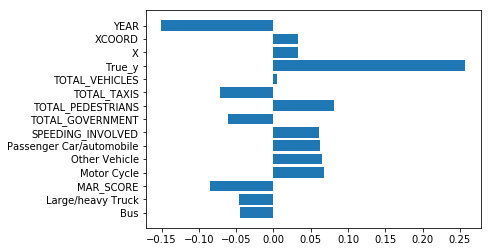

In [67]:
plt.barh(coeffs.values, coeffs.index)